In [1]:
from __future__ import division, unicode_literals
from textblob import TextBlob as tb
import numpy as np
import gensim

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import re
import pandas as pd

def clean_str(string):
    """
    Tokenization/string cleaning strings
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip('\n').strip().lower()

def load_data(path, file_name):
    df = pd.read_csv(path + file_name, sep='\t', header=None)
    df.columns = ['hardcoded_question']
    for i in df.index:
        df['hardcoded_question'][i] = clean_str(df['hardcoded_question'][i])
    return df

def load_test_data(path, file_name):
    df = pd.read_csv(path + file_name, sep='\t', header=None)
    df.columns = ['hardcoded_question', 'user_question']
    for i in df.index:
        df['hardcoded_question'][i] = clean_str(df['hardcoded_question'][i])
        df['user_question'][i] = clean_str(df['user_question'][i])
    return df 

# upload data
print "loading data...\n"
print "loading hardcoded_question_set...\n"
path_train = '/Users/vincentchabot/Desktop/capstone/Data2/'
file_name_train = 'test2.txt' 
hardcoded_question_set = load_data(path_train, file_name_train)
print "loading test set...\n"
path_test = '/Users/vincentchabot/Desktop/capstone/Data2/'
file_name_test = 'test_set2.tsv' 
test_set = load_test_data(path_test, file_name_test)

loading data...

loading hardcoded_question_set...

loading test set...



In [3]:
model = gensim.models.Word2Vec.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True) 
num_features = 300 

In [4]:
import nltk
import inflect

keep_pos = ['NN', 'NNS']

def CBOW(question):
    feature_vec = np.zeros((num_features), dtype="float32")
    words_embedded = 0
    for word in question:
        word_vec = model[word]
        feature_vec += word_vec
        words_embedded += 1
    feature_vec /= float(words_embedded)
    return feature_vec

def keep_nouns(question):
    '''
    From a sentence, return list of tuples [(word, POS)] if POS in keep_pos (by default : noun(s))
    '''
    question_tokens = nltk.word_tokenize(question[0])
    question_tagged = nltk.pos_tag(question_tokens)
    question_tagged_nouns = [question_tagged[i] 
                            for i in range(len(question_tagged)) 
                            if question_tagged[i][1] 
                            in keep_pos]
    return question_tagged_nouns

def plural_to_singular(tagged_nouns):
    '''
    Putting all nouns to singular form (because similarity(A,A') > similarity(A,As'))
    '''
    p = inflect.engine()

    question_nouns = []
    for nouns in tagged_nouns:
        if nouns[1] != 'NNS':
            question_nouns.append(nouns[0]) 
        else:
            if p.singular_noun(nouns[0]) != False:
                question_nouns.append(p.singular_noun(nouns[0]))
    return question_nouns

def generate_embedding_array(sentence):
    pos = plural_to_singular(keep_nouns(sentence))
    X = np.zeros((len(pos)+1, num_features))
    X[0] = CBOW(pos)
    i = 1
    for word in pos:
        X[i] = model[word]
        i +=1
    return X

In [5]:
s1 = ['what is the number of users in the database']
s2 = ['what is the number of customers in the database']
s3 = ['what is the number of cars in the database']

sentences = [s1[0],s2[0],s3[0]]

X1 = generate_embedding_array(s1)
X2 = generate_embedding_array(s2)
X3 = generate_embedding_array(s3)
X = np.concatenate((X1,X2,X3))

In [6]:
X.shape

(12, 300)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
X1_reduced = pca.transform(X1)
X2_reduced = pca.transform(X2)
X3_reduced = pca.transform(X3)

In [13]:
X_reduced *= 10 
X1_reduced *= 10 
X2_reduced *= 10 
X3_reduced *= 10 

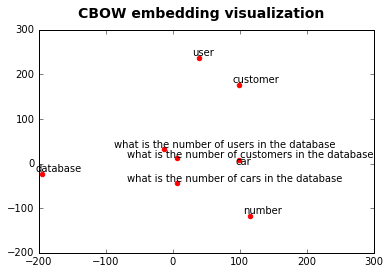

In [16]:
import matplotlib.pyplot as plt
% matplotlib inline
# np.savetxt(os.path.join(FLAGS.checkpoint_path,'tsne_proj.txt'),tsne_data)

fig = plt.figure()
fig.suptitle('CBOW embedding visualization', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)

plt.scatter(X1_reduced[2,0],X1_reduced[2,1],color='red')
ax.annotate('user', xy=(X1_reduced[2,0],X1_reduced[2,1]), xytext=(X1_reduced[2,0]-10,X1_reduced[2,1]+5))
plt.scatter(X2_reduced[2,0],X2_reduced[2,1],color='red')
ax.annotate('customer', xy=(X2_reduced[2,0],X2_reduced[2,1]), xytext=(X2_reduced[2,0]-10,X2_reduced[2,1]+5))
plt.scatter(X3_reduced[2,0],X3_reduced[2,1],color='red')
ax.annotate('car', xy=(X3_reduced[2,0],X3_reduced[2,1]), xytext=(X3_reduced[2,0]-5,X3_reduced[2,1]-10))
plt.scatter(X3_reduced[1,0],X3_reduced[1,1],color='red')
ax.annotate('number', xy=(X3_reduced[2,0],X3_reduced[2,1]), xytext=(X3_reduced[1,0]-10,X3_reduced[1,1]+5))
plt.scatter(X3_reduced[3,0],X3_reduced[3,1],color='red')
ax.annotate('database', xy=(X3_reduced[3,0],X3_reduced[3,1]), xytext=(X3_reduced[3,0]-10,X3_reduced[3,1]+5))

plt.scatter(X1_reduced[0,0],X1_reduced[0,1],color='red')
ax.annotate(s1[0], xy=(X1_reduced[0,0],X1_reduced[0,1]), xytext=(X1_reduced[0,0]-75,X1_reduced[0,1]+5))
plt.scatter(X2_reduced[0,0],X2_reduced[0,1],color='red')
ax.annotate(s2[0], xy=(X2_reduced[0,0],X2_reduced[0,1]), xytext=(X2_reduced[0,0]-75,X2_reduced[0,1]+1))
plt.scatter(X3_reduced[0,0],X3_reduced[0,1],color='red')
ax.annotate(s3[0], xy=(X3_reduced[0,0],X3_reduced[0,1]), xytext=(X3_reduced[0,0]-75,X3_reduced[0,1]+5))

#plt.plot([X1_reduced[0,0], X2_reduced[0,0], X3_reduced[0,0]],[X1_reduced[0,1],X2_reduced[0,1],X3_reduced[0,1]],'ro', color='black')
# plt.savefig(os.path.join(FLAGS.checkpoint_path,'tsne.png'))
plt.axis([-200, 300, -200, 300])

plt.show()

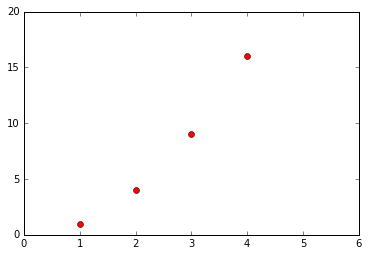

In [12]:
plt.plot([1,2,3,4], [1,4,9,16], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()

In [ ]:
#from sklearn.manifold import TSNE
#import matplotlib

#tsne = TSNE()
#tsne.fit(X_reduced)
#X1_tsne = tsne.tansform(X1)
#X2_tsne = tsne.tansform(X2)
#X3_tsne = tsne.tansform(X3)

In [ ]:
print X1_tsne.shape

# np.savetxt(os.path.join(FLAGS.checkpoint_path,'tsne_proj.txt'),tsne_data)
#plt.scatter(tsne_data[0],tsne_data[1])
#plt.savefig(os.path.join(FLAGS.checkpoint_path,'tsne.png'))